## BlackSheep Cookbook Exploration

The Black Sheep Analysis allows researchers to find trends in abnormal protein enrichment among patients in CPTAC datasets. In this Cookbook, we will go through the steps needed to perform a full Black Sheep Analysis.

### Step 1a: Import Dependencies
First, import the necessary dependencies and load cptac data.

In [20]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import cptac
import binarization_functions as bf
import blackSheepCPTACmoduleCopy as blsh
en = cptac.Endometrial()

Checking that data files are up-to-date...
100% [..................................................................................] 649 / 649
Data check complete.
endometrial data version: 2.1

Loading acetylproteomics data...
Loading clinical data...
Loading CNA data...
Loading definitions data...
Loading miRNA data...
Loading phosphoproteomics_gene data...
Loading phosphoproteomics_site data...
Loading proteomics data...
Loading somatic data...
Loading somatic_binary data...
Loading transcriptomics_circular data...
Loading transcriptomics_linear data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but analysis may not be
published until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter cptac.embargo() to open the webpage for more details.


## Step 1b: Load Data and Choose Omics Table

In [2]:
en = cptac.Endometrial()
proteomics = en.get_proteomics()
mRNA = en.get_transcriptomics()
phospho = en.get_phosphoproteomics()
clinical = en.get_clinical()

Checking that data files are up-to-date...
100% [..................................................................................] 649 / 649
Data check complete.
endometrial data version: 2.1

Loading acetylproteomics data...
Loading clinical data...
Loading CNA data...
Loading definitions data...
Loading miRNA data...
Loading phosphoproteomics_gene data...
Loading phosphoproteomics_site data...
Loading proteomics data...
Loading somatic data...
Loading somatic_binary data...
Loading transcriptomics_circular data...
Loading transcriptomics_linear data...

 ******PLEASE READ******
CPTAC is a community resource project and data are made available
rapidly after generation for community research use. The embargo
allows exploring and utilizing the data, but analysis may not be
published until July 1, 2019. Please see
https://proteomics.cancer.gov/data-portal/about/data-use-agreement or
enter cptac.embargo() to open the webpage for more details.


In [3]:
#Append Genomics_subtype and MSI_status to en.get_clinical()
df= en.get_derived_molecular()
clinical['MSI_status'] = df['MSI_status']
clinical['Genomics_subtype'] = df['Genomics_subtype']

## Step 2: Determine what attributes you would like to A/B test. 
For this analysis, we will iteratively go through the various columns in the clinical dataset, to determine if any of them have trends within them for protein enrichment.

In [4]:
#Create a copy of the original Clinical DataFrame and drop irrelevant columns.
annotations = pd.DataFrame(clinical.copy())
annotations = annotations.drop(['Patient_ID', 
                                'Treatment_naive', 
                                'Tumor_purity', 
                                'Gender', 
                                'Tumor_Site_Other'], axis=1)

## Step 2a: Binarize column values

In [8]:
%%timeit
tumor_map = {'Tumor':'Normal_Tumor', 
             'Adjacent_normal':'Other_tumor', 
             'Enriched_normal':'Other_tumor', 
             'Myometrium_normal':'Other_tumor'}

annotations['Proteomics_Tumor_Normal'] = bf.binarizeCategorical(clinical, 
                                                                'Proteomics_Tumor_Normal', 
                                                                tumor_map)

country_map = {'United States':'US', 
               'Ukraine':'Other', 
               'Other_specify':'Other', 
               'Poland':'Other'}

annotations['Country'] = bf.binarizeCategorical(clinical, 
                                                'Country', 
                                                country_map)

annotations['BMI'] = bf.binarizeRange(clinical, 'BMI', 18, 25, 
                                      'Healthy', 'Unhealthy')

annotations['Age'] = bf.binarizeCutOff(clinical, 'Age', 
                                       60.0, 'Old', 'Young')
FIGO_map = {'FIGO grade 1':'Low_grade', 
            'FIGO grade 2':'High_grade', 
            'FIGO grade 3':'High_grade'}

annotations['Histologic_Grade_FIGO'] = bf.binarizeCategorical(clinical, 
                                                              'Histologic_Grade_FIGO', 
                                                              FIGO_map)
Myo_map = {'under 50 %':'under_50%', 
           '50 % or more': '50%_or_more', 
           'Not identified': 'under_50%'}

annotations['Myometrial_invasion_Specify'] = bf.binarizeCategorical(clinical, 
                                                                    'Myometrial_invasion_Specify', 
                                                                    Myo_map)
path_tumor_map = {'pT1a (FIGO IA)':'Not_FIGO_III', 
            'pT1b (FIGO IB)':'Not_FIGO_III', 
            'pT2 (FIGO II)':'Not_FIGO_III', 
            'pT1 (FIGO I)':'Not_FIGO_III', 
            'pT3a (FIGO IIIA)':'FIGO_III', 
            'pT3b (FIGO IIIB)':'FIGO_III'}

annotations['Path_Stage_Primary_Tumor-pT'] = bf.binarizeCategorical(clinical, 
                                                                    'Path_Stage_Primary_Tumor-pT', 
                                                                    path_tumor_map)

path_lymph_map = {'pN0':'Not_FIGO_III', 
                  'pNX':'Not_FIGO_III', 
                  'pN1 (FIGO IIIC1)':'FIGO_III', 
                  'pN2 (FIGO IIIC2)':'FIGO_III'}

annotations['Path_Stage_Reg_Lymph_Nodes-pN'] = bf.binarizeCategorical(clinical, 
                                                                      'Path_Stage_Reg_Lymph_Nodes-pN', 
                                                                      path_lymph_map)
clin_stage_map = {'cM0':'cM0_or_cM1', 
                  'cM1':'cM0_or_cM1', 
                  'Staging Incomplete':'Staging_Incomplete'}

annotations['Clin_Stage_Dist_Mets-cM'] = bf.binarizeCategorical(clinical, 
                                                                'Clin_Stage_Dist_Mets-cM', 
                                                                clin_stage_map)

path_stage_map = {'Staging Incomplete': 'No_distant_metastasis', 
                  'No pathologic evidence of distant metastasis':'No_distant_metastasis', 
                  'pM1':'Distant_Metastasis'}

annotations['Path_Stage_Dist_Mets-pM'] = bf.binarizeCategorical(clinical, 
                                                                'Path_Stage_Dist_Mets-pM', 
                                                                path_stage_map)

tumor_stage_map = {'Stage I':'Stage_I_or_II', 
                   'Stage II':'Stage_I_or_II', 
                   'Stage III':'Stage_III_or_IV', 
                   'Stage IV':'Stage_III_or_IV'}

annotations['tumor_Stage-Pathological'] = bf.binarizeCategorical(clinical, 
                                                               'tumor_Stage-Pathological', 
                                                               tumor_stage_map)
FIGO_stage_map = {'IA':'I_or_II', 
                  'IB':'I_or_II', 
                  'II':'I_or_II', 
                  'IIIA':'III_or_IV', 
                  'IIIC1':'III_or_IV', 
                  'IVB':'III_or_IV', 
                  'IIIC2':'III_or_IV', 
                  'IIIB':'III_or_IV'}

annotations['FIGO_stage'] = bf.binarizeCategorical(clinical, 
                                                   'FIGO_stage', 
                                                   FIGO_stage_map)
diabetes_map = {'No':'No', 
                'Yes':'Yes', 
                'Unknown':'No'}

annotations['Diabetes'] = bf.binarizeCategorical(clinical, 
                                                 'Diabetes', 
                                                 diabetes_map)

race_map = {'White':'White', 
            'Black or African American':'Not_White', 
            'Asian':'Not_White', 
            'Not Reported':'Not_White'}

annotations['Race'] = bf.binarizeCategorical(clinical, 
                                             'Race', 
                                             race_map)

ethnicity_map = {'Not-Hispanic or Latino':'Not_Hispanic', 
                 'Not reported':'Not_Hispanic', 
                 'Hispanic or Latino':'Hispanic'}

annotations['Ethnicity'] = bf.binarizeCategorical(clinical, 
                                                  'Ethnicity', 
                                                  ethnicity_map)

tumor_site_map = {'Other, specify':'Not_Anterior', 
                  'Anterior endometrium':'Anterior', 
                  'Posterior endometrium':'Not_Anterior'}

annotations['Tumor_Site'] = bf.binarizeCategorical(clinical, 
                                                   'Tumor_Site', 
                                                   tumor_site_map)

annotations['Tumor_Size_cm'] = bf.binarizeCutOff(clinical, 
                                                'Tumor_Size_cm', 4.0, 
                                                'Large_tumor', 
                                                'Small_tumor')

num_pregnancies_map = {2:'Less_than_3', 
                       1:'Less_than_3', 
                       'None':'Less_than_3', 
                       None:'Less_than_3', 
                       3:'3_or_more', 
                       '4 or more':'3_or_more'}

annotations['Num_full_term_pregnancies'] = bf.binarizeCategorical(clinical, 
                                                                  'Num_full_term_pregnancies', 
                                                                  num_pregnancies_map)

genomics_map = {'MSI-H':'MSI-H', 
                'CNV_low':'Other_subtype', 
                'CNV_high':'Other_subtype', 
                'POLE':'Other_subtype'}

annotations['Genomics_subtype'] = bf.binarizeCategorical(clinical, 
                                                         'Genomics_subtype', 
                                                         genomics_map)

96.1 ms ± 16.4 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


## Step 3: Perform outliers analysis

In [9]:
outliers_prot = blsh.make_outliers_table(proteomics, iqrs=1.5, 
                                         up_or_down='up', 
                                         aggregate=False, 
                                         frac_table=False)

outliers_phospho = blsh.make_outliers_table(phospho, iqrs=1.5,
                                            up_or_down='up', 
                                            aggregate=False, 
                                            frac_table=False)

C:\Users\Daniel\AppData\Local\conda\conda\envs\Research\lib\site-packages\numpy\lib\nanfunctions.py:1354: RuntimeWarning: All-NaN slice encountered
  overwrite_input, interpolation)


## Step 4: Wrap your A/B test into the outliers analysis, and create a table

In [12]:
results_prot = blsh.compare_groups_outliers(outliers_prot, 
                                            annotations)

results_phospho = blsh.compare_groups_outliers(outliers_phospho, 
                                               annotations)

No rows had outliers in at least 0.3 of Proteomics_Tumor_Normal Normal_Tumor samples
Testing 14 rows for enrichment in Proteomics_Tumor_Normal Other_tumor samples
No rows had outliers in at least 0.3 of Country Other samples
No rows had outliers in at least 0.3 of Country US samples
Testing 2 rows for enrichment in Histologic_Grade_FIGO High_grade samples
Testing 1 rows for enrichment in Histologic_Grade_FIGO Low_grade samples
No rows had outliers in at least 0.3 of Myometrial_invasion_Specify under_50% samples
Testing 7 rows for enrichment in Myometrial_invasion_Specify 50%_or_more samples
No rows had outliers in at least 0.3 of Histologic_type Endometrioid samples
Testing 626 rows for enrichment in Histologic_type Serous samples
No rows had outliers in at least 0.3 of Path_Stage_Primary_Tumor-pT Not_FIGO_III samples
Testing 241 rows for enrichment in Path_Stage_Primary_Tumor-pT FIGO_III samples
No rows had outliers in at least 0.3 of Path_Stage_Reg_Lymph_Nodes-pN Not_FIGO_III samples

Many of the output values from compare_group_outliers are NaN, so here we will get rid of the NaN values for visualization purposes.

In [13]:
results_prot = results_prot.dropna(axis=0, how='all')
results_phospho = results_phospho.dropna(axis=0, how='all')

## Step 5: Visualize these enrichments

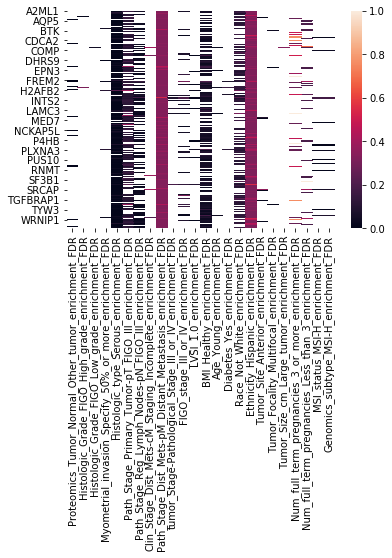

In [14]:
sns.heatmap(results_prot)
plt.show()

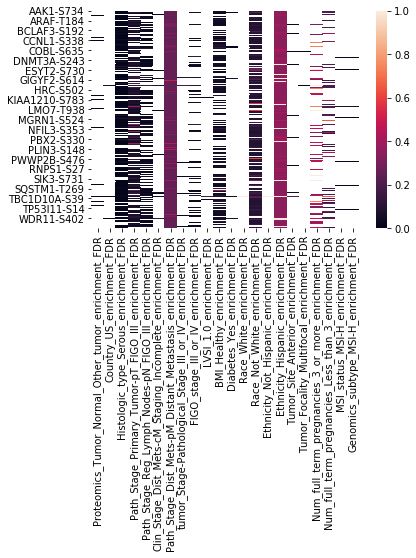

In [15]:
sns.heatmap(results_phospho)
plt.show()

## Step 6: Determine significant enrichments, and link with cancer drug database.

In [21]:
#Check for significant columns in proteomics
print("TESTING FOR PROTEOMICS:")
sig_cols = []
for col in results_prot.columns:
    sig_col = bf.significantEnrichments(results_prot, col, 0.01)
    sig_col

print("TESTING FOR PHOSPHOPROTEOMICS:")
for col in results_phospho:
    sig_col = bf.significantEnrichments(results_phospho, col, 0.01)
    sig_col 

TESTING FOR PROTEOMICS:
14 significant protein enrichments in Proteomics_Tumor_Normal_Other_tumor

No significant results in Histologic_Grade_FIGO_High_grade

No significant results in Histologic_Grade_FIGO_Low_grade

2 significant protein enrichments in Myometrial_invasion_Specify_50%_or_more

412 significant protein enrichments in Histologic_type_Serous

No significant results in Path_Stage_Primary_Tumor-pT_FIGO_III

1 significant protein enrichment in Path_Stage_Reg_Lymph_Nodes-pN_FIGO_III:

No significant results in Clin_Stage_Dist_Mets-cM_Staging_Incomplete

No significant results in Path_Stage_Dist_Mets-pM_Distant_Metastasis

No significant results in tumor_Stage-Pathological_Stage_III_or_IV

No significant results in FIGO_stage_III_or_IV

8 significant protein enrichments in LVSI_1.0

No significant results in BMI_Healthy

2 significant protein enrichments in Age_Young

No significant results in Diabetes_Yes

No significant results in Race_Not_White

No significant results in Et

In [17]:
column = 'BMI_Healthy_enrichment_FDR'
sig_results_BMI_Healthy = bf.significantEnrichments(results_prot, column)
sig_results_BMI_Healthy.head()

94 significant protein enrichments in BMI_Healthy



,BMI_Healthy_P_values
ABHD14A-ACY1,0.040382
ABT1,0.032828
ACAD10,0.049402
AKAP8L,0.032828
ANKRD10,0.040382


In [18]:
column = 'Histologic_type_Serous_enrichment_FDR'
sig_results_Serous = bf.significantEnrichments(results_phospho, column)
sig_results_Serous.head()

485 significant protein enrichments in Histologic_type_Serous



,Histologic_type_Serous_P_values
AATF-S316,0.000931
ABCC5-S505,0.005951
ACACA-S62,0.000300
ACACA-S66,0.002108
ACAP2-S379,0.000729
